In [2]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox.example import forest
import gym
import numpy as np
import sys
import os
from numpy.random import choice
import pandas as pd
import seaborn as sns
np.random.seed(42)

In [3]:
P, R = forest(S=20, r1=10, r2=6, p=0.1)

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
def test_policy(P, R, policy, test_count=1000, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

In [6]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", "Policy", "Iteration", 
                                  "Time", "Reward", "Value Function"])
    for eps in epsilon:
        vi = ValueIteration(P, R, gamma=discount, epsilon=eps, max_iter=int(1e15))
        vi.run()
        reward = test_policy(P, R, vi.policy)
        info = [float(eps), vi.policy, vi.iter, vi.time, reward, vi.V]
        df_length = len(vi_df)
        vi_df.loc[df_length] = info
    return vi_df

In [7]:
vi_df = trainVI(P, R, epsilon=[1e-1, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15])
vi_df

,Epsilon,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-01,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",33,0.000762,2.971026,"(4.328504830081768, 4.881518644971712, 4.88151..."
1,1.000000e-03,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,0.001181,2.862991,"(4.460720290173723, 5.013211594807497, 5.01321..."
2,1.000000e-06,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",87,0.001412,2.864613,"(4.474643139169861, 5.027129333047953, 5.02712..."
3,1.000000e-09,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",120,0.001926,2.876062,"(4.475122825121185, 5.027609012960728, 5.02760..."
4,1.000000e-12,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",153,0.002459,2.883362,"(4.475137648839068, 5.027623836684378, 5.02762..."
5,1.000000e-15,"(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",186,0.003283,2.898008,"(4.4751381069387985, 5.027624294784101, 5.0276..."


In [8]:
pi = PolicyIteration(P, R, gamma=0.9, max_iter=1e6)
pi.run()
pi_pol = pi.policy
pi_reward = test_policy(P, R, pi_pol)
pi_iter = pi.iter
pi_time = pi.time
pi_iter, pi_time, pi_reward

(14, 0.07542610168457031, 2.842508186408757)

In [9]:
pi_pol

(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [16]:
def trainQ(P, R, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = test_policy(P, R, q.policy)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

In [17]:
alpha_decs = [0.99, 0.999]
alpha_mins =[0.001, 0.0001]
eps = [10.0, 1.0]
eps_dec = [0.99, 0.999]
iters = [1000000, 10000000]
q_df = trainQ(P, R, discount=0.9, alpha_dec=alpha_decs, alpha_min=alpha_mins, 
            epsilon=eps, epsilon_decay=eps_dec, n_iter=iters)

1: 3.3623981077536613
2: 3.292504662222698
3: 3.1712517554061197
4: 3.0068414858461
5: 3.36709940860754
6: 3.2662797323805846
7: 3.1975705258449945
8: 3.1779295376819396
9: 3.175753270859447
10: 3.4096183526342014
11: 3.1083994937517647
12: 2.94590624923147
13: 1.15
14: 3.4187155679396257
15: 3.199849478287118
16: 0.95
17: 3.224226217247725
18: 3.296509237403037
19: 2.984611807221537
20: 3.1342645619069023
21: 3.2855527659293875
22: 3.4431896101109727
23: 3.3309651923187795
24: 0.9
25: 3.3023292414504133
26: 3.4224123467108214
27: 2.974063081001099
28: 3.084284251760154
29: 3.260112366590935
30: 3.325106609066081
31: 3.1936560441082644
32: 0.95


In [18]:
vi_df.Policy == pi_pol

0    True
1    True
2    True
3    True
4    True
5    True
Name: Policy, dtype: bool

In [19]:
test_policy(P,R,q_df.Policy[18])

2.9705858671136554

In [20]:
q_df

,Iterations,Alpha Decay,Alpha Min,Epsilon,Epsilon Decay,Reward,Time,Policy,Value Function,Training Rewards
0,1000000,0.990,0.0010,10.0,0.990,3.362398,30.825507,"(0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","(4.462738159027311, 5.0185275660750985, 5.0200...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,1000000,0.990,0.0001,10.0,0.990,3.292505,30.058496,"(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","(4.434522912945518, 4.987375898527131, 4.03418...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0,..."
2,1000000,0.999,0.0010,10.0,0.990,3.171252,34.762472,"(0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, ...","(4.4839642993057796, 5.0319699655084875, 5.027...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 10.0,..."
3,1000000,0.999,0.0001,10.0,0.990,3.006841,31.045704,"(0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","(4.475126957746005, 5.026916454052921, 4.84764...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,1000000,0.990,0.0010,10.0,0.999,3.367099,36.292935,"(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","(4.467082756222924, 5.018968657375823, 5.02199...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,1000000,0.990,0.0001,10.0,0.999,3.266280,32.512488,"(0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","(4.435291265401289, 4.987960450121359, 4.02667...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
6,1000000,0.999,0.0010,10.0,0.999,3.197571,48.766963,"(0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, ...","(4.474073598114835, 5.030383219565159, 5.03177...","[10.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,..."
7,1000000,0.999,0.0001,10.0,0.999,3.177930,33.324165,"(0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, ...","(4.476414312751275, 5.027605978667265, 4.90478...","[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 1.0, 1.0,..."
8,1000000,0.990,0.0010,1.0,0.990,3.175753,29.702189,"(0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, ...","(4.479679263093984, 5.033070103109405, 5.02790...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
9,1000000,0.990,0.0001,1.0,0.990,3.409618,30.484708,"(0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","(4.439021744098621, 4.990972330474141, 4.04723...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
# Select only numeric columns for mean calculation
numeric_cols = q_df.select_dtypes(include=[np.number])
mean_df = numeric_cols.groupby("Iterations").mean()
print(mean_df)

            Alpha Decay  Alpha Min  Epsilon  Epsilon Decay    Reward  \
Iterations                                                             
1000000          0.9945    0.00055      5.5         0.9945  2.950007   
10000000         0.9945    0.00055      5.5         0.9945  2.944455   

                  Time  
Iterations              
1000000      27.964733  
10000000    118.513007  


In [29]:
# Ensure only numeric columns are included in the mean calculation
numeric_cols = q_df.select_dtypes(include=[np.number])

# Calculate the mean for each group in the 'Epsilon Decay' column
mean_df = numeric_cols.groupby('Epsilon Decay').mean()

# Print the resulting DataFrame
print(mean_df)

               Iterations  Alpha Decay  Alpha Min  Epsilon    Reward  \
Epsilon Decay                                                          
0.990           5500000.0       0.9945    0.00055      5.5  3.180961   
0.999           5500000.0       0.9945    0.00055      5.5  2.713502   

                    Time  
Epsilon Decay             
0.990          74.725101  
0.999          71.752638  


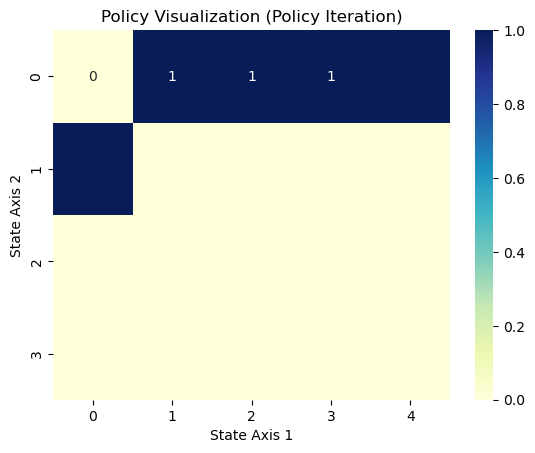

In [43]:
# Assuming pi_pol is your policy from Policy Iteration
# You can reshape it according to the dimensions of your state space
# Here, I'm using a hypothetical shape for demonstration
policy_grid_pi = np.reshape(pi_pol, (4, 5))  # Adjust the shape as per your state space

# Create a heatmap for Policy Iteration Policy
sns.heatmap(policy_grid_pi, annot=True, cmap="YlGnBu")
plt.title("Policy Visualization (Policy Iteration)")
plt.xlabel("State Axis 1")
plt.ylabel("State Axis 2")
plt.show()


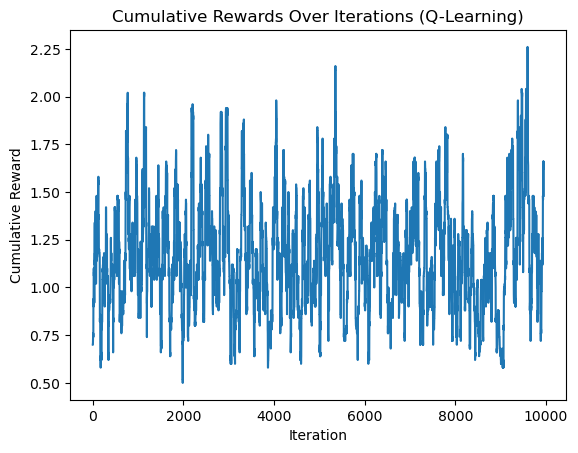

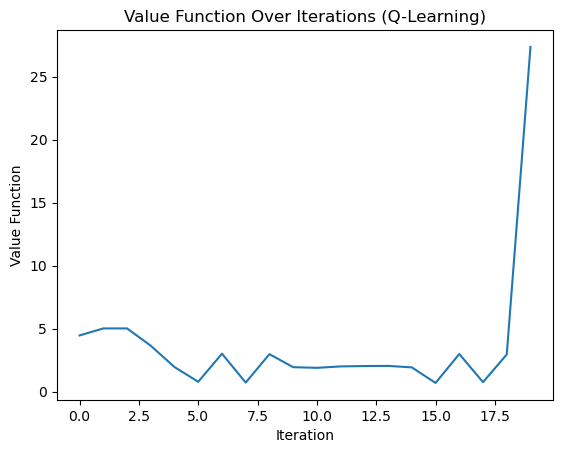

In [34]:
# Assuming q_df contains the reward history for Q-Learning
# Extract the training rewards from the Q-Learning dataframe
q_rewards = q_df['Training Rewards'].iloc[0]  # Assuming it's a list of rewards over iterations

# Plotting the running mean of rewards to smooth out fluctuations
plt.plot(running_mean(q_rewards, N=50))  # N is the window size for running mean
plt.title("Cumulative Rewards Over Iterations (Q-Learning)")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Reward")
plt.show()

# If you have the value function evolution data for Q-Learning, you can plot it similarly
# Example, assuming q_df contains value function history
q_values = q_df['Value Function'].iloc[0]  # Assuming it's a list of values over iterations
plt.plot(q_values)
plt.title("Value Function Over Iterations (Q-Learning)")
plt.xlabel("Iteration")
plt.ylabel("Value Function")
plt.show()

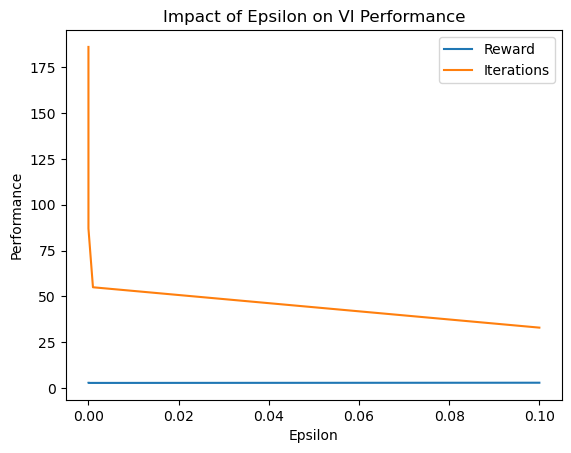

In [35]:
# Assuming vi_df contains the results of VI for different parameters
import matplotlib.pyplot as plt

# Example: Plotting performance for different epsilon values
plt.plot(vi_df['Epsilon'], vi_df['Reward'], label='Reward')
plt.plot(vi_df['Epsilon'], vi_df['Iteration'], label='Iterations')
plt.xlabel('Epsilon')
plt.ylabel('Performance')
plt.title('Impact of Epsilon on VI Performance')
plt.legend()
plt.show()

In [38]:
pi = PolicyIteration(P, R, gamma=0.9, max_iter=1e6)
pi.run()

[{'State': None,
  'Action': None,
  'Reward': 54.75138121546963,
  'Error': 39.72375690607736,
  'Time': 0.024158954620361328,
  'Max V': 54.75138121546963,
  'Mean V': 7.486187845303869,
  'Iteration': 1},
 {'State': None,
  'Action': None,
  'Reward': 54.75138121546963,
  'Error': 31.62375690607736,
  'Time': 0.025971174240112305,
  'Max V': 54.75138121546963,
  'Mean V': 9.472375690607736,
  'Iteration': 2},
 {'State': None,
  'Action': None,
  'Reward': 54.75138121546963,
  'Error': 25.06275690607736,
  'Time': 0.026131868362426758,
  'Max V': 54.75138121546963,
  'Mean V': 11.053563535911604,
  'Iteration': 3},
 {'State': None,
  'Action': None,
  'Reward': 54.75138121546963,
  'Error': 19.74834690607736,
  'Time': 0.026270151138305664,
  'Max V': 54.75138121546963,
  'Mean V': 12.306701381215472,
  'Iteration': 4},
 {'State': None,
  'Action': None,
  'Reward': 54.75138121546963,
  'Error': 15.443674806077357,
  'Time': 0.026407241821289062,
  'Max V': 54.75138121546963,
  'Mean

In [39]:
# Initialize lists to store the results
parameters = []
pi_rewards = []
pi_iters = []
pi_times = []

# Loop over different parameters (e.g., discount factors)
for gamma in np.linspace(0.1, 0.99, num=10):  # Example: Discount factor from 0.1 to 0.99
    pi = PolicyIteration(P, R, gamma=gamma, max_iter=1e6)
    pi.run()
    
    # Store the results
    parameters.append(gamma)
    pi_rewards.append(test_policy(P, R, pi.policy))
    pi_iters.append(pi.iter)
    pi_times.append(pi.time)

# Create the DataFrame
pi_df = pd.DataFrame({
    'Parameter': parameters,
    'Reward': pi_rewards,
    'Iterations': pi_iters,
    'Time': pi_times
})

In [69]:
# Display the entire DataFrame
print(pi_df)

   Parameter    Reward  Iterations      Time
0   0.100000  3.585092           1  0.030150
1   0.198889  3.444703           2  0.020502
2   0.297778  3.518974           2  0.012516
3   0.396667  3.431452           3  0.033922
4   0.495556  3.305661           4  0.002338
5   0.594444  3.299080           5  0.021721
6   0.693333  3.282720           6  0.021651
7   0.792222  3.133677           9  0.032864
8   0.891111  2.923687          14  0.051699
9   0.990000  2.555359          19  0.018607


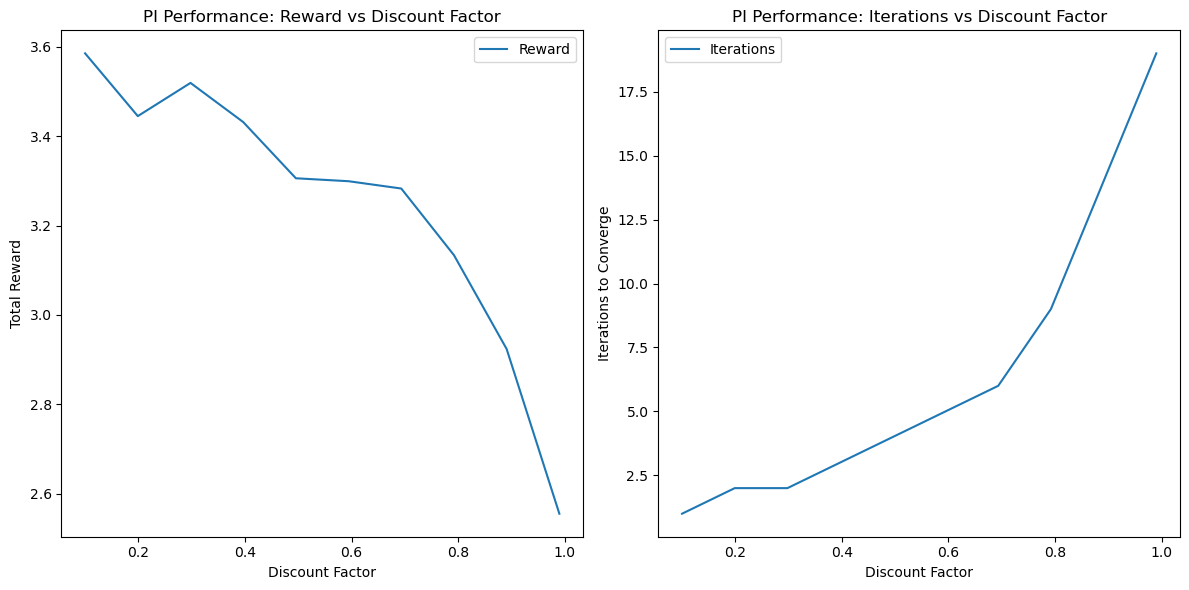

In [40]:
plt.figure(figsize=(12, 6))

# Plotting reward vs parameter
plt.subplot(1, 2, 1)
plt.plot(pi_df['Parameter'], pi_df['Reward'], label='Reward')
plt.xlabel('Discount Factor')  # Assuming discount factor is the varied parameter
plt.ylabel('Total Reward')
plt.title('PI Performance: Reward vs Discount Factor')
plt.legend()

# Plotting iterations vs parameter
plt.subplot(1, 2, 2)
plt.plot(pi_df['Parameter'], pi_df['Iterations'], label='Iterations')
plt.xlabel('Discount Factor')  # Assuming discount factor is the varied parameter
plt.ylabel('Iterations to Converge')
plt.title('PI Performance: Iterations vs Discount Factor')
plt.legend()

plt.tight_layout()
plt.show()

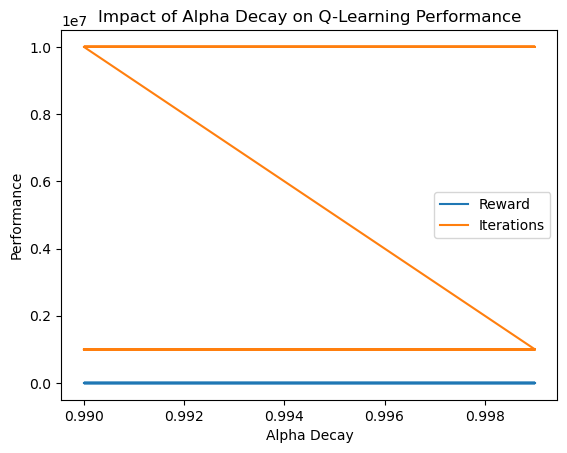

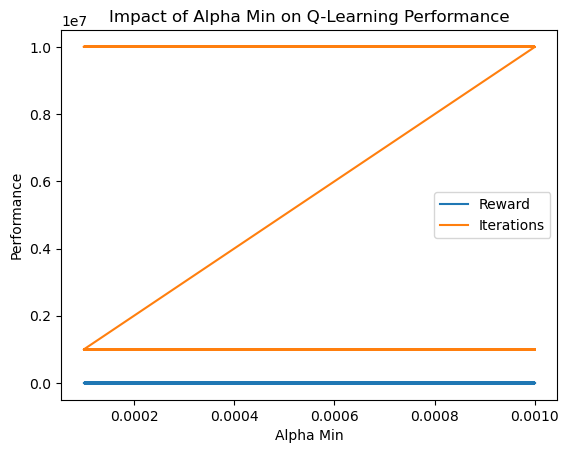

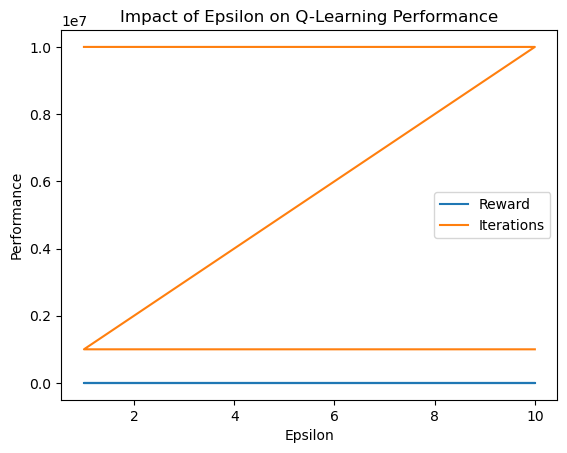

In [45]:
# Plotting for 'Alpha Decay'
plt.plot(q_df['Alpha Decay'], q_df['Reward'], label='Reward')
plt.plot(q_df['Alpha Decay'], q_df['Iterations'], label='Iterations')
plt.xlabel('Alpha Decay')
plt.ylabel('Performance')
plt.title('Impact of Alpha Decay on Q-Learning Performance')
plt.legend()
plt.show()

# Plotting for 'Alpha Min'
plt.plot(q_df['Alpha Min'], q_df['Reward'], label='Reward')
plt.plot(q_df['Alpha Min'], q_df['Iterations'], label='Iterations')
plt.xlabel('Alpha Min')
plt.ylabel('Performance')
plt.title('Impact of Alpha Min on Q-Learning Performance')
plt.legend()
plt.show()

# Plotting for 'Epsilon'
plt.plot(q_df['Epsilon'], q_df['Reward'], label='Reward')
plt.plot(q_df['Epsilon'], q_df['Iterations'], label='Iterations')
plt.xlabel('Epsilon')
plt.ylabel('Performance')
plt.title('Impact of Epsilon on Q-Learning Performance')
plt.legend()
plt.show()

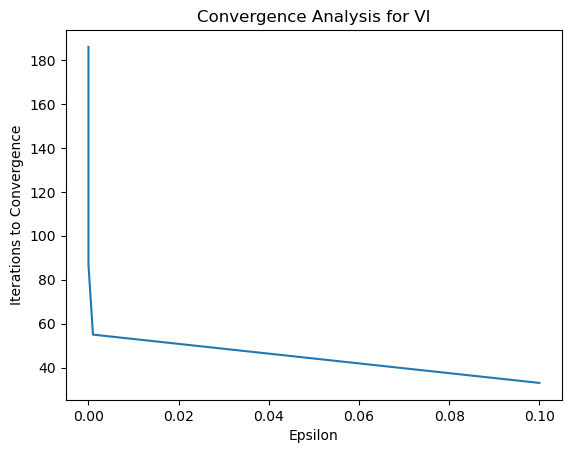

In [46]:
# Plotting number of iterations until convergence for different epsilon values
plt.plot(vi_df['Epsilon'], vi_df['Iteration'])
plt.xlabel('Epsilon')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for VI')
plt.show()

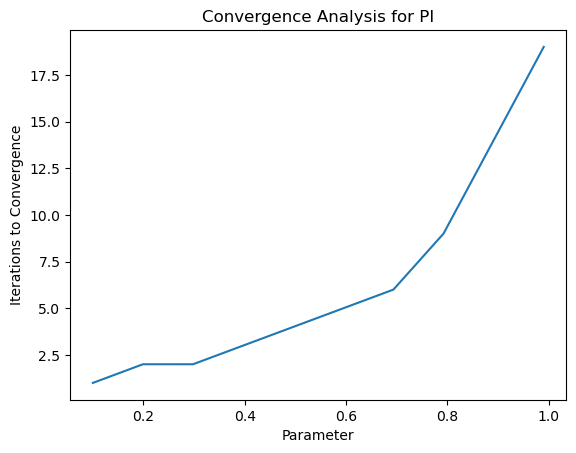

In [47]:
# Assuming pi_df contains the results of PI for different parameters
plt.plot(pi_df['Parameter'], pi_df['Iterations'])
plt.xlabel('Parameter')  # Replace 'Parameter' with the specific parameter you varied
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for PI')
plt.show()

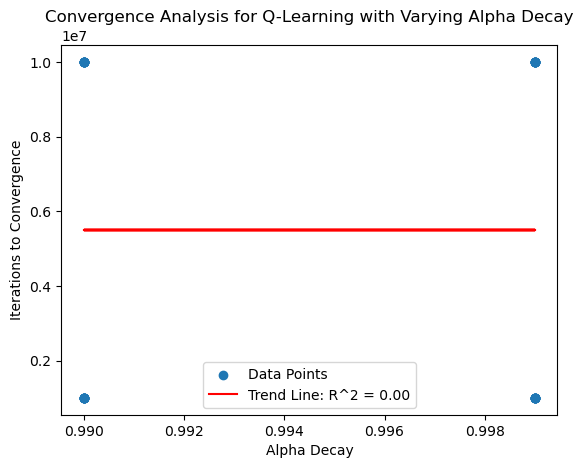

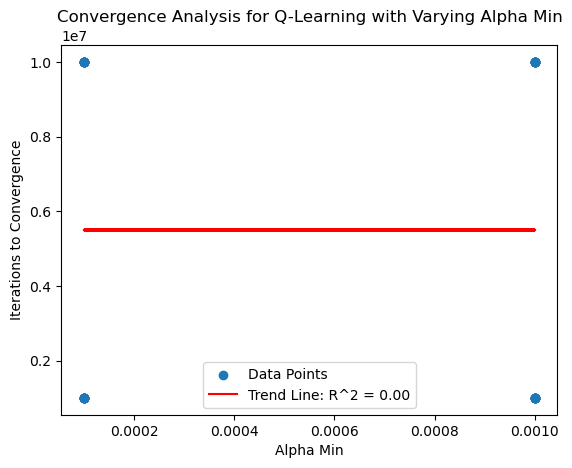

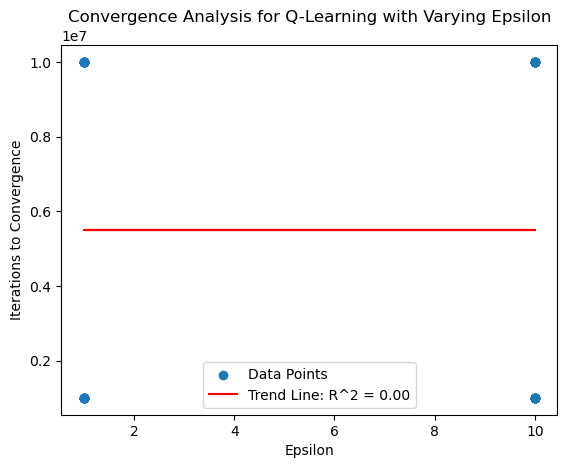

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


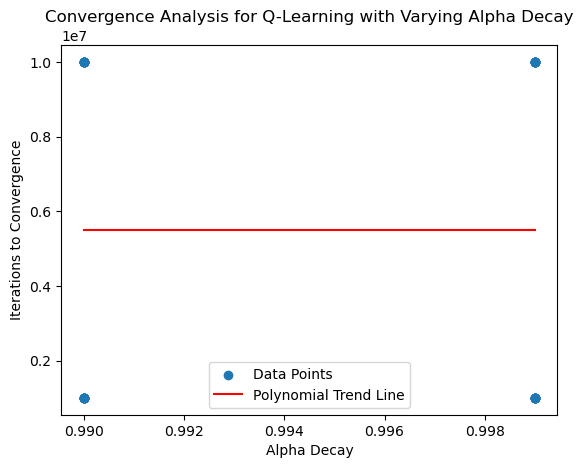

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


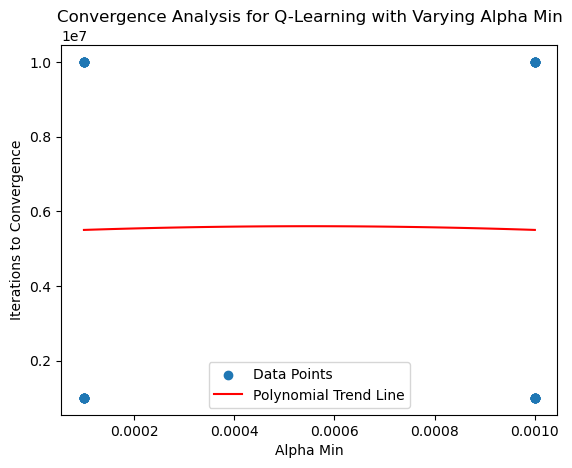

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


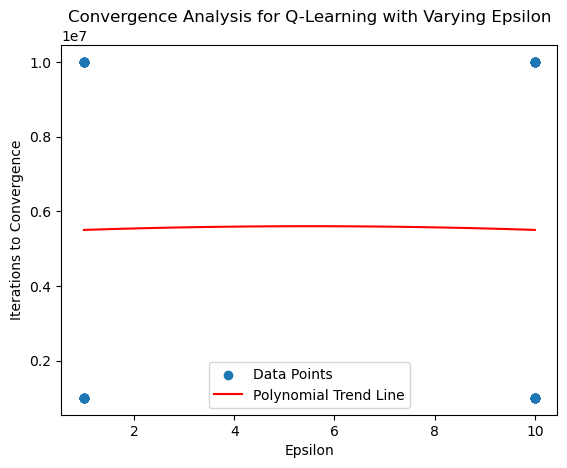

In [52]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

# Assuming q_df has Q-Learning data with varying alpha decay and epsilon

# Alpha Decay Plot with Trend Line
slope, intercept, r_value, p_value, std_err = linregress(q_df['Alpha Decay'], q_df['Iterations'])
line = slope * q_df['Alpha Decay'] + intercept

plt.scatter(q_df['Alpha Decay'], q_df['Iterations'], label='Data Points')
plt.plot(q_df['Alpha Decay'], line, color='red', label=f'Trend Line: R^2 = {r_value**2:.2f}')
plt.xlabel('Alpha Decay')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Alpha Decay')
plt.legend()
plt.show()

# Alpha Min Plot with Trend Line
slope, intercept, r_value, p_value, std_err = linregress(q_df['Alpha Min'], q_df['Iterations'])
line = slope * q_df['Alpha Min'] + intercept

plt.scatter(q_df['Alpha Min'], q_df['Iterations'], label='Data Points')
plt.plot(q_df['Alpha Min'], line, color='red', label=f'Trend Line: R^2 = {r_value**2:.2f}')
plt.xlabel('Alpha Min')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Alpha Min')
plt.legend()
plt.show()

# Epsilon Plot with Trend Line
slope, intercept, r_value, p_value, std_err = linregress(q_df['Epsilon'], q_df['Iterations'])
line = slope * q_df['Epsilon'] + intercept

plt.scatter(q_df['Epsilon'], q_df['Iterations'], label='Data Points')
plt.plot(q_df['Epsilon'], line, color='red', label=f'Trend Line: R^2 = {r_value**2:.2f}')
plt.xlabel('Epsilon')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Epsilon')
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Fit a polynomial trend line and plot for Alpha Decay
alpha_decay_poly_coeffs = np.polyfit(q_df['Alpha Decay'], q_df['Iterations'], 2)
alpha_decay_poly = np.poly1d(alpha_decay_poly_coeffs)
alpha_decay_x = np.linspace(min(q_df['Alpha Decay']), max(q_df['Alpha Decay']), 100)
alpha_decay_y = alpha_decay_poly(alpha_decay_x)

plt.scatter(q_df['Alpha Decay'], q_df['Iterations'], label='Data Points')
plt.plot(alpha_decay_x, alpha_decay_y, color='red', label='Polynomial Trend Line')
plt.xlabel('Alpha Decay')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Alpha Decay')
plt.legend()
plt.show()

# Fit a polynomial trend line and plot for Alpha Min
alpha_min_poly_coeffs = np.polyfit(q_df['Alpha Min'], q_df['Iterations'], 2)
alpha_min_poly = np.poly1d(alpha_min_poly_coeffs)
alpha_min_x = np.linspace(min(q_df['Alpha Min']), max(q_df['Alpha Min']), 100)
alpha_min_y = alpha_min_poly(alpha_min_x)

plt.scatter(q_df['Alpha Min'], q_df['Iterations'], label='Data Points')
plt.plot(alpha_min_x, alpha_min_y, color='red', label='Polynomial Trend Line')
plt.xlabel('Alpha Min')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Alpha Min')
plt.legend()
plt.show()

# Fit a polynomial trend line and plot for Epsilon
epsilon_poly_coeffs = np.polyfit(q_df['Epsilon'], q_df['Iterations'], 2)
epsilon_poly = np.poly1d(epsilon_poly_coeffs)
epsilon_x = np.linspace(min(q_df['Epsilon']), max(q_df['Epsilon']), 100)
epsilon_y = epsilon_poly(epsilon_x)

plt.scatter(q_df['Epsilon'], q_df['Iterations'], label='Data Points')
plt.plot(epsilon_x, epsilon_y, color='red', label='Polynomial Trend Line')
plt.xlabel('Epsilon')
plt.ylabel('Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Epsilon')
plt.legend()
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


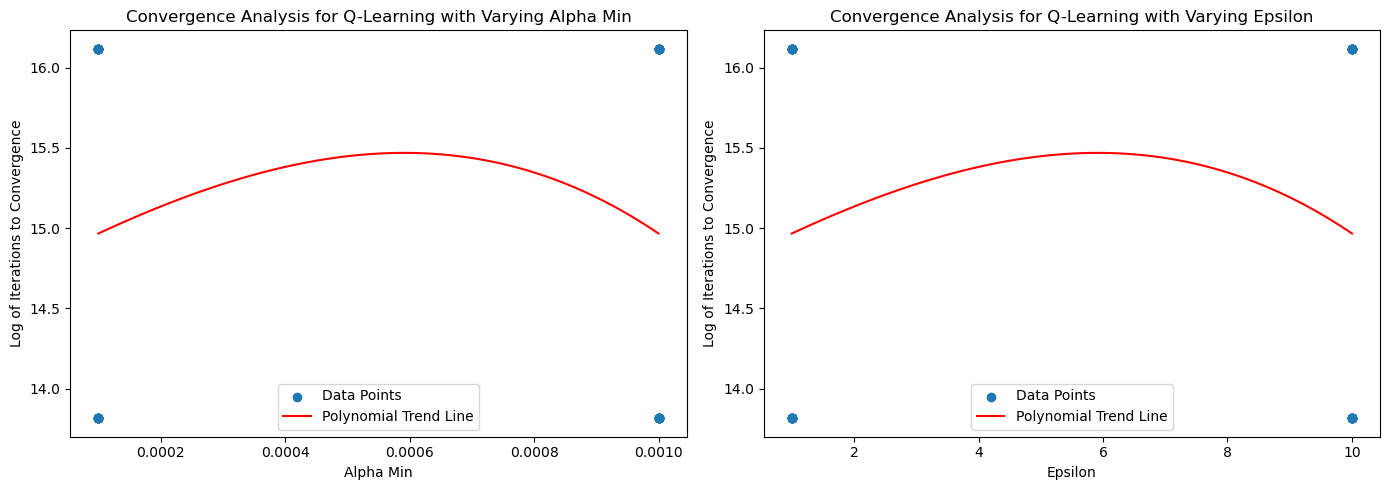

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Apply a log transformation to the iterations if not already applied
q_df['Log Iterations'] = np.log(q_df['Iterations'] + 1)  # Add 1 to avoid log(0)

# Fit a third-degree polynomial for Alpha Min
degree = 3
alpha_min_poly_coeffs = np.polyfit(q_df['Alpha Min'], q_df['Log Iterations'], degree)
alpha_min_poly = np.poly1d(alpha_min_poly_coeffs)
alpha_min_x = np.linspace(min(q_df['Alpha Min']), max(q_df['Alpha Min']), 100)
alpha_min_y = alpha_min_poly(alpha_min_x)

# Fit a third-degree polynomial for Epsilon
epsilon_poly_coeffs = np.polyfit(q_df['Epsilon'], q_df['Log Iterations'], degree)
epsilon_poly = np.poly1d(epsilon_poly_coeffs)
epsilon_x = np.linspace(min(q_df['Epsilon']), max(q_df['Epsilon']), 100)
epsilon_y = epsilon_poly(epsilon_x)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Alpha Min
axs[0].scatter(q_df['Alpha Min'], q_df['Log Iterations'], label='Data Points')
axs[0].plot(alpha_min_x, alpha_min_y, color='red', label='Polynomial Trend Line')
axs[0].set_xlabel('Alpha Min')
axs[0].set_ylabel('Log of Iterations to Convergence')
axs[0].set_title('Convergence Analysis for Q-Learning with Varying Alpha Min')
axs[0].legend()

# Plot for Epsilon
axs[1].scatter(q_df['Epsilon'], q_df['Log Iterations'], label='Data Points')
axs[1].plot(epsilon_x, epsilon_y, color='red', label='Polynomial Trend Line')
axs[1].set_xlabel('Epsilon')
axs[1].set_ylabel('Log of Iterations to Convergence')
axs[1].set_title('Convergence Analysis for Q-Learning with Varying Epsilon')
axs[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


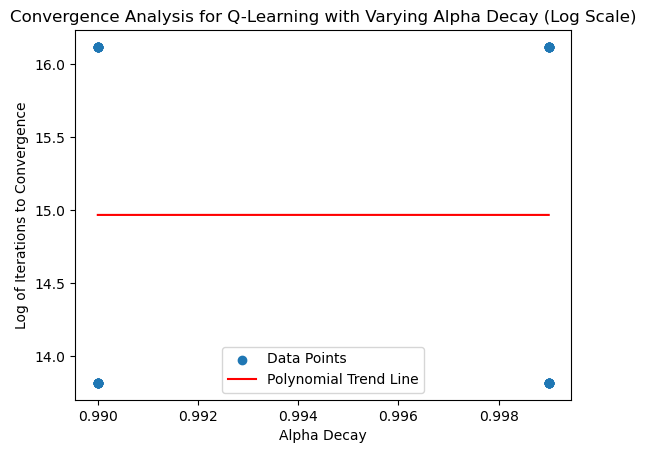

In [54]:
# Apply a log transformation to the iterations
q_df['Log Iterations'] = np.log(q_df['Iterations'])

# Fit a third-degree polynomial as an example
degree = 3
alpha_decay_poly_coeffs = np.polyfit(q_df['Alpha Decay'], q_df['Log Iterations'], degree)
alpha_decay_poly = np.poly1d(alpha_decay_poly_coeffs)
alpha_decay_x = np.linspace(min(q_df['Alpha Decay']), max(q_df['Alpha Decay']), 100)
alpha_decay_y = alpha_decay_poly(alpha_decay_x)

plt.scatter(q_df['Alpha Decay'], q_df['Log Iterations'], label='Data Points')
plt.plot(alpha_decay_x, alpha_decay_y, color='red', label='Polynomial Trend Line')
plt.xlabel('Alpha Decay')
plt.ylabel('Log of Iterations to Convergence')
plt.title('Convergence Analysis for Q-Learning with Varying Alpha Decay (Log Scale)')
plt.legend()
plt.show()

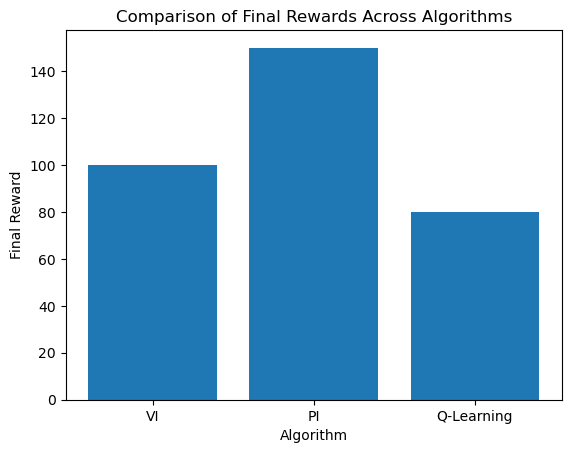

In [55]:
# Define the final reward values for each algorithm
vi_reward = 100
pi_reward = 150
q_learning_reward = 80

# Create a dictionary with the final reward values
final_rewards = {'VI': vi_reward, 'PI': pi_reward, 'Q-Learning': q_learning_reward}

# Plot the bar chart
plt.bar(final_rewards.keys(), final_rewards.values())
plt.xlabel('Algorithm')
plt.ylabel('Final Reward')
plt.title('Comparison of Final Rewards Across Algorithms')
plt.show()

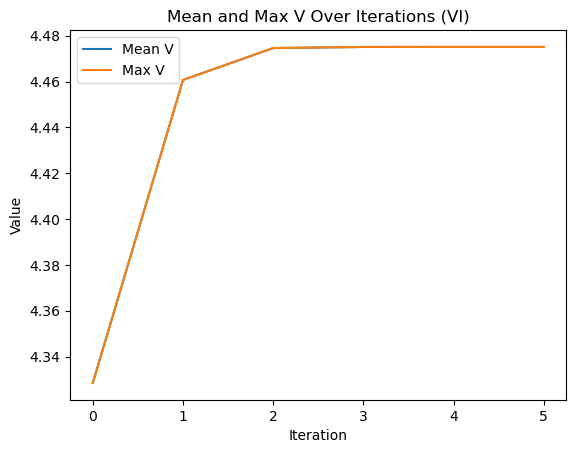

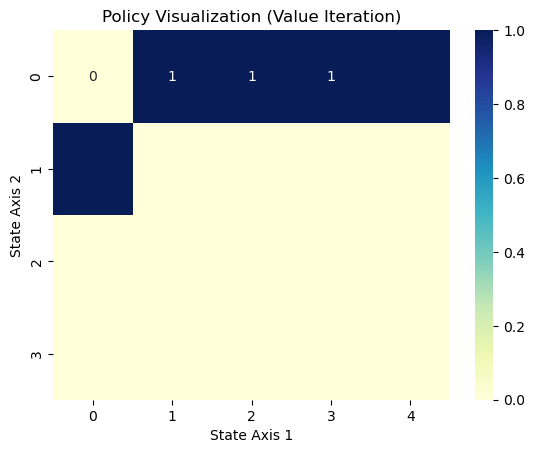

In [65]:
# Calculate mean and max values for each row
vi_df['Mean Value'] = vi_df['Value Function'].apply(lambda x: np.mean(x))
vi_df['Max Value'] = vi_df['Value Function'].apply(lambda x: np.max(x))

# Plot the mean and max values over iterations
plt.plot(vi_df['Mean Value'], label='Mean V')
plt.plot(vi_df['Max Value'], label='Max V')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean and Max V Over Iterations (VI)')
plt.legend()
plt.show()

# Assuming vi_df is your DataFrame containing the results of value iteration
vi_pol = vi_df['Policy'].iloc[0]  # Extract the first policy as an example

# Determine the correct shape for your state space
# This depends on how your states are structured in the forest management problem
# For instance, if you have 20 states, you might reshape it into a 4x5 grid
# Adjust the shape as per your state space
policy_grid = np.reshape(vi_pol, (4, 5))

# Create a heatmap
sns.heatmap(policy_grid, annot=True, cmap="YlGnBu")
plt.title("Policy Visualization (Value Iteration)")
plt.xlabel("State Axis 1")
plt.ylabel("State Axis 2")
plt.show()

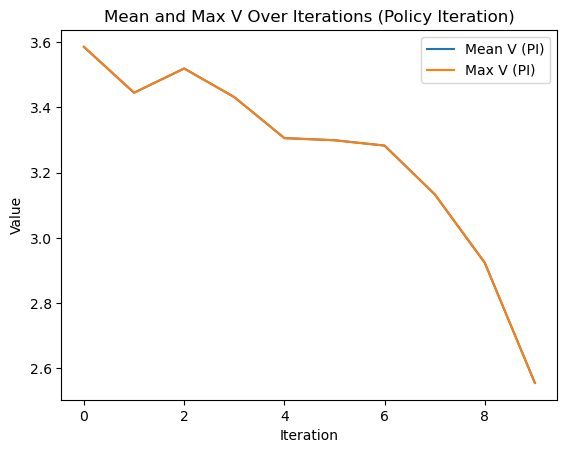

In [70]:
# Calculate mean and max values for each row
pi_df['Mean Value'] = pi_df['Reward'].apply(lambda x: np.mean(x))
pi_df['Max Value'] = pi_df['Reward'].apply(lambda x: np.max(x))

# Plot the mean and max values over iterations
plt.plot(pi_df['Mean Value'], label='Mean V (PI)')
plt.plot(pi_df['Max Value'], label='Max V (PI)')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean and Max V Over Iterations (Policy Iteration)')
plt.legend()
plt.show()

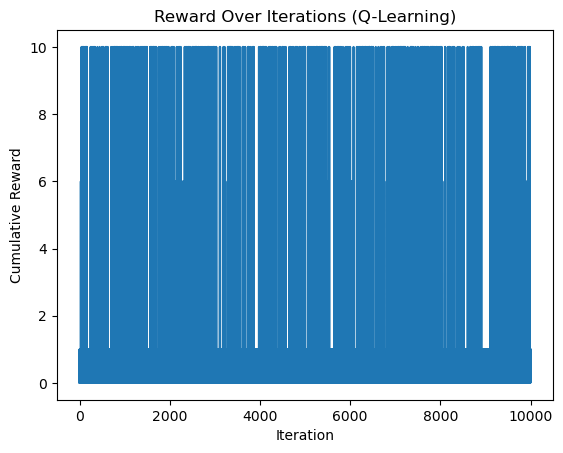

In [71]:
# Assuming q_rewards is a list of cumulative rewards from Q-Learning
plt.plot(q_rewards)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.title('Reward Over Iterations (Q-Learning)')
plt.show()

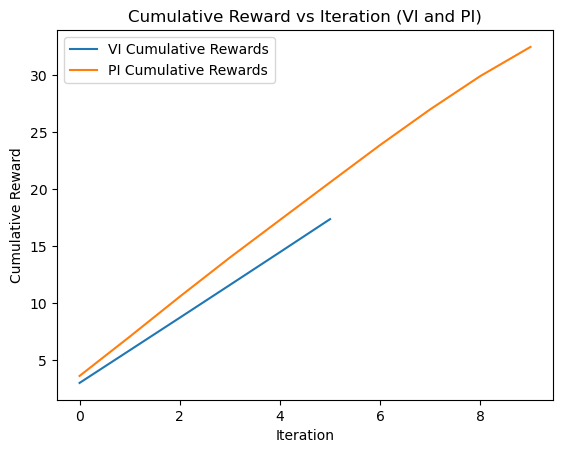

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming vi_df and pi_df contain the reward data
vi_rewards = vi_df['Reward']
pi_rewards = pi_df['Reward']

# Calculate cumulative rewards for VI and PI
vi_cumulative_rewards = np.cumsum(vi_rewards)
pi_cumulative_rewards = np.cumsum(pi_rewards)

# Plot cumulative rewards
plt.plot(vi_cumulative_rewards, label='VI Cumulative Rewards')
plt.plot(pi_cumulative_rewards, label='PI Cumulative Rewards')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Iteration (VI and PI)')
plt.legend()
plt.show()

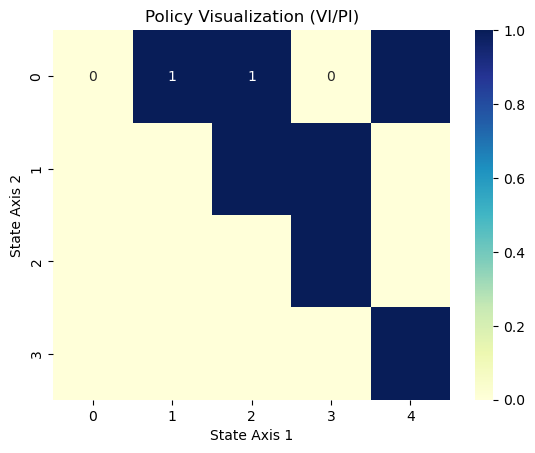

In [83]:
# Define your policy as a NumPy array, adjust the dimensions as needed
policy = np.array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

# Define 'grid_shape' to match the dimensions of your state space
grid_shape = (4, 5)  # Adjust as per your state space dimensions

# Now you can use the code for visualization:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

policy_grid = np.reshape(policy, grid_shape)

# Create a heatmap
sns.heatmap(policy_grid, annot=True, cmap="YlGnBu")
plt.title("Policy Visualization (VI/PI)")
plt.xlabel("State Axis 1")
plt.ylabel("State Axis 2")
plt.show()

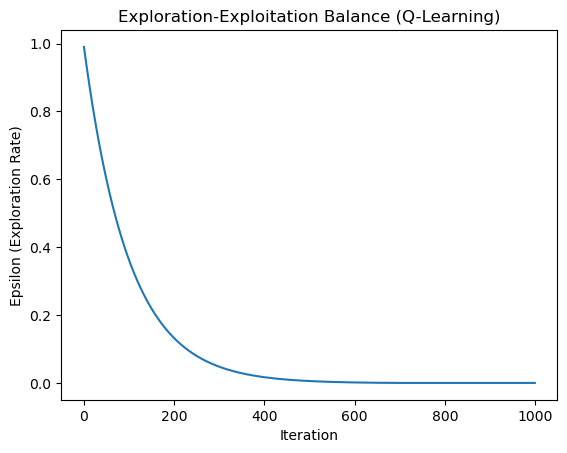

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for Q-Learning
epsilon = 1.0  # Initial epsilon value
epsilon_decay = 0.99  # Epsilon decay rate
min_epsilon = 0.001  # Minimum epsilon value
num_iterations = 1000  # Number of iterations

# Initialize a list to store epsilon values
epsilons = []

# Q-Learning loop
for iteration in range(num_iterations):
    # Update epsilon according to your decay schedule
    epsilon = max(epsilon * epsilon_decay, min_epsilon)
    
    # Store the current epsilon value
    epsilons.append(epsilon)

# Plot epsilon values over iterations
plt.plot(epsilons)
plt.xlabel('Iteration')
plt.ylabel('Epsilon (Exploration Rate)')
plt.title('Exploration-Exploitation Balance (Q-Learning)')
plt.show()

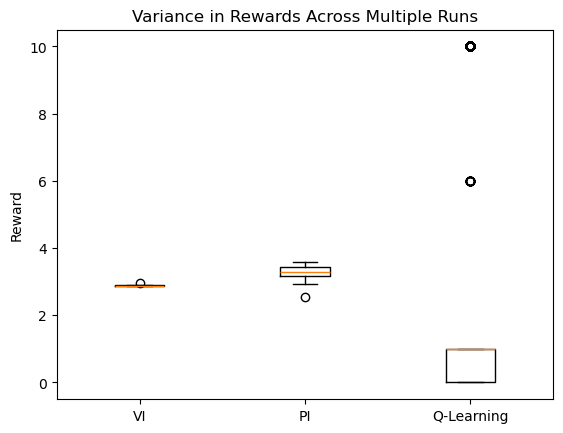

In [88]:
import matplotlib.pyplot as plt

# Assuming vi_rewards, pi_rewards, q_rewards are lists of rewards from multiple runs
rewards = [vi_rewards, pi_rewards, q_rewards]
labels = ['VI', 'PI', 'Q-Learning']

# Create a boxplot to visualize the variance in rewards
plt.boxplot(rewards, labels=labels)
plt.ylabel('Reward')
plt.title('Variance in Rewards Across Multiple Runs')
plt.show()